# Download

In [1]:
folder='data/embryo/dataset/'
matrix='chimera_wt_data.tar.gz'

In [8]:
!mkdir -p $folder

In [16]:
!curl https://content.cruk.cam.ac.uk/jmlab/$matrix > $folder/$matrix && cd $folder && tar -xzvf $matrix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  196M  100  196M    0     0  1344k      0  0:02:30  0:02:30 --:--:-- 1383k
chimera-wt/
chimera-wt/meta.tab
chimera-wt/._meta.tab
chimera-wt/raw_counts.mtx
chimera-wt/sizefactors.tab
chimera-wt/corrected_pcas.rds
chimera-wt/genes.tsv
chimera-wt/README.txt
chimera-wt/._README.txt


In [19]:
matrix='atlas_data.tar.gz'
!curl https://content.cruk.cam.ac.uk/jmlab/$matrix > $folder/$matrix && cd $folder && tar -xzvf $matrix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1592M  100 1592M    0     0  1355k      0  0:20:03  0:20:03 --:--:-- 1365k
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
atlas/
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
atlas/corrected_pcas.rds
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
atlas/genes.tsv
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended hea

In [20]:
matrix='chimera_tal1_data.tar.gz'
!curl https://content.cruk.cam.ac.uk/jmlab/$matrix > $folder/$matrix && cd $folder && tar -xzvf $matrix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  572M  100  572M    0     0  1354k      0  0:07:13  0:07:13 --:--:-- 1352k
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
chimera-tal1/
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
chimera-tal1/corrected_pcas.rds
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
chimera-tal1/genes.tsv
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring

In [23]:
!rm -rf data/embryo/dataset/*.tar.gz

# Read and preprocess

In [24]:
import disentangler as dt
from disentangler.dependencies import *

In [25]:
def read_matrix(path):
    
    atlas_mtx = sc.read_mtx(path + 'raw_counts.mtx').T

    atlas_obs = pd.read_csv(path + 'meta.tab', sep = '\t')
    atlas_genes = pd.read_csv(path + 'genes.tsv', header = None, sep = '\t')

    atlas_genes.columns = ['ensemble','gene_symbol']
    atlas_genes.gene_symbol = atlas_genes.gene_symbol.str.upper()

    atlas = anndata.AnnData(
        X = atlas_mtx.X,
        obs = atlas_obs.set_index('barcode'),
        var = atlas_genes.set_index('gene_symbol'),
    )

    atlas.var_names_make_unique()
    
    return atlas

In [29]:
atlas = read_matrix(folder + 'atlas/')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
chimera_wt = read_matrix(folder + 'chimera-wt/')

In [31]:
chimera_tal = read_matrix(folder + 'chimera-tal1/')

In [32]:
data = anndata.concat({
            'atlas' : atlas,
            'chimera-wt' : chimera_wt,
            'chimera-ko' : chimera_tal,
        }, label = 'experiment', index_unique=':',
        join = 'outer',
    )

data.obs_names_make_unique()

In [33]:
data = data[(data.obs.doublet != True) & (data.obs.stripped != True)]
data.obs = data.obs.drop(columns = ['doublet','stripped'])

In [34]:
data

AnnData object with n_obs × n_vars = 185915 × 29453
    obs: 'cell', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'tomato', 'stage.mapped', 'celltype.mapped', 'haem_closestcell', 'haem_subcluster', 'experiment'

In [35]:
data.var['MT-gene'] = data.var_names.str.startswith('MT')
data.var['pseudogene'] = data.var_names.str.startswith('GM')

In [36]:
sc.pp.filter_genes(data, min_cells = 50)

sc.pp.calculate_qc_metrics(data, log1p=False, inplace=True,
                          qc_vars = ['MT-gene'], percent_top=None)

In [37]:
data = data[:, ~(data.var['MT-gene'] | data.var['pseudogene'])]

In [38]:
data.raw = data

sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, min_disp= 0.)
data.var.highly_variable.sum()

data.var['exog'] = data.var.highly_variable.copy()
data.var['endog'] = data.var.exog & (data.var.dispersions_norm > 0.5)

data.layers['counts'] = data.raw.to_adata().X

model_data = data[:, data.var.exog | data.var.exog]

del data

In [40]:
model_data.obs['sequencing.batch'] = model_data.obs['sequencing.batch'].fillna(4.)
model_data.obs['sequencing.batch'][model_data.obs.experiment == 'chimera-ko']+=1

model_data.obs['batch_id'] = model_data.obs['sequencing.batch'].astype(str)
model_data.obs['day'] = model_data.obs.stage.str.strip('E').replace('mixed_gastrulation','0.0').astype(float)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
problem_columns = model_data.obs.columns[model_data.obs.isna().any(0)]
problem_cols_df = model_data.obs[problem_columns].copy()
problem_cols_df.to_csv(folder + 'metadata.tsv', sep = '\t')

In [81]:
model_data.obs = model_data.obs.iloc[:,~model_data.obs.columns.isin(problem_columns)]
model_data.write_h5ad(folder + 'anndata.h5ad')

# Read

In [1]:
import disentangler as dt
from disentangler.dependencies import *
folder='data/embryo/dataset/'

In [2]:
model_data = anndata.read_h5ad(folder + 'anndata.h5ad')
meta = pd.read_csv(folder + 'metadata.tsv', sep = '\t')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,7,8,13,16,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
model_data.obs = model_data.obs.join(meta.set_index('barcode'))

In [4]:
!mkdir -p figure3

In [4]:
model_data.obs['Tal1 -/-'] = model_data.obs['tomato'].fillna('-').astype(str).map({'False' : '-', 'True' : '+', '-' : '-'})

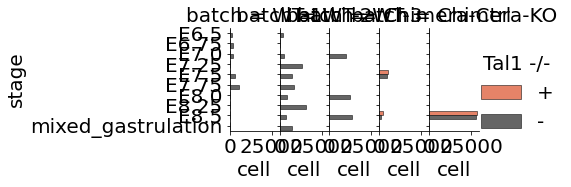

In [5]:
batch_v_stage = model_data.obs.groupby(['sequencing.batch','stage','Tal1 -/-']).count()['cell'].reset_index()
#batch_v_stage['clipped_cell'] = np.clip(batch_v_stage.cell,0., 2e4)

batch_v_stage['batch'] = batch_v_stage['sequencing.batch'].map({1.0 : 'WT-1', 2.0 : 'WT-2', 3.0 : 'WT-3',
                                      4.0 : 'Chimera-Ctrl', 5.0 : 'Chimera-KO'})

sns.catplot(
    data = batch_v_stage,
    col='batch',
    y='stage',
    x = 'cell',
    kind='bar',
    order = sorted(batch_v_stage.stage.unique().astype(str)),
    palette= {'+' : sns.color_palette('RdGy', n_colors=7)[1], '-' : sns.color_palette('RdGy')[-1]},
    hue = 'Tal1 -/-',
    aspect = 0.5,
    height = 3.,
    linewidth = 0.5,
    edgecolor = 'black',
    saturation = 1.,
    dodge = True,
    facet_kws = dict(gridspec_kws = dict(wspace = 0.)),
)
#plt.savefig('figure3/batch_cell_heatmap.svg')

batch_v_stage = np.log10(batch_v_stage + 1)

sns.heatmap(batch_v_stage[sorted(batch_v_stage.columns[:-1], key = lambda x : float(x[1:]))], cmap='Greys',
           vmin = 2.5)

plt.savefig('figure3/batch_cell_heatmap.svg')

In [6]:
celltype_palette = {k : '#' + v if type(v) == str else '#EEEEEE' for k,v in dict(model_data.obs[['celltype','colour']].drop_duplicates().values).items()}

celltype_umap_kwargs = dict(
    color = 'celltype', frameon=False, legend_loc='none',
    palette=celltype_palette, title = '',
)

day_umap_kwargs = dict(frameon = False, 
                       color_map = sns.color_palette('mako_r', as_cmap=True), title = '',
                       vmin = 6.5, vmax = 9.1, legend_loc='none', color = 'day')

batch_palette = dict(zip(
    ['5.0','2.0', '3.0','1.0','4.0'],#model_data.obs.groupby('batch_id').count()['cell'].sort_values().index.values,
    sns.color_palette('muted', n_colors=5)
))

batch_umap_kwargs = dict(
    color = 'batch_id', palette = batch_palette, frameon = False, title = '', 
    legend_loc = 'none',
)

# PCA plot

In [8]:
sc.tl.pca(model_data, n_comps=50, use_highly_variable=True)

In [9]:
sc.pp.neighbors(model_data, n_pcs=50, n_neighbors = 15)
sc.tl.umap(model_data, min_dist = 0.1, negative_sample_rate=3)

In [10]:
!mkdir -p figure3/pca/

... storing 'theiler' as categorical
... storing 'celltype' as categorical
... storing 'colour' as categorical
... storing 'haem_subclust' as categorical
... storing 'endo_trajectoryName' as categorical
... storing 'endo_gutCluster' as categorical
... storing 'stage.mapped' as categorical
... storing 'celltype.mapped' as categorical
... storing 'haem_closestcell' as categorical
... storing 'haem_subcluster' as categorical
... storing 'Tal1 -/-' as categorical


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

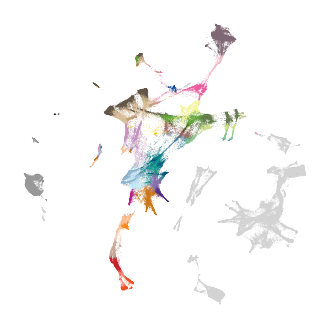

In [11]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.umap(model_data, **celltype_umap_kwargs, ax = ax, s = 0.5, show = False)
#plt.savefig('figure3/pca/celltypes.png', bbox_inches = 'tight', dpi = 300)

In [12]:
import matplotlib
matplotlib.rc('font', size = 7)

In [13]:
model_data.obs['day_squared'] = (model_data.obs.day-6.5)**3

In [14]:
day_umap_kwargs = dict(frameon = False, 
                       color_map = sns.color_palette('mako_r', as_cmap=True), title = '',
                       legend_loc='none', color = 'day_squared', vmin = 0.)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

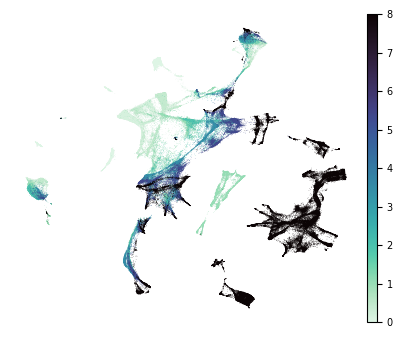

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
sc.pl.umap(model_data, ax = ax, **day_umap_kwargs, s = 0.5, show = False)
#plt.savefig('figure3/pca/day.png', bbox_inches = 'tight', dpi = 300)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

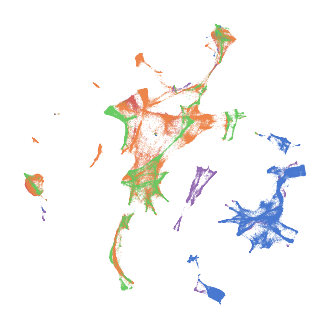

In [16]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.umap(model_data, ax = ax, **batch_umap_kwargs, s= 0.5, show = False)
#plt.savefig('figure3/pca/batch.png', bbox_inches = 'tight', dpi = 300)

# MIRA

In [7]:
model_data.obs['is_chimera'] = model_data.obs['experiment'].str.startswith('chimera')
model_data.obs['is_mixed_embryos'] = model_data.obs.stage == 'mixed_gastrulation'

model_data.obs['batch-stage-group'] = list(map(lambda b : '{}-{}'.format(*b), model_data.obs[['batch_id','stage']].values))

In [18]:
model = mira.topics.TopicModel(
    *model_data.shape,
    seed = 0,
    categorical_covariates=['batch_id','is_chimera','is_mixed_embryos'],
    continuous_covariates=['day'],
    exogenous_key='exog',
    latent_space='dirichlet',
    feature_type='expression',
    counts_layer='counts',
    min_learning_rate = 1e-3,
    max_learning_rate = 0.1,    
)

In [ ]:
model_data.obs['batch-stage-group'] = list(map(lambda b : '{}-{}'.format(*b), model_data.obs[['batch_id','stage']].values))

train, test = mira.topics.SpeedyTuner.train_test_split(model_data, stratify=model_data.obs_vector('batch-stage-group'),
                                                      train_size = 0.9)

!rm -rf $folder/full_train $folder/full_test

model.write_ondisk_dataset(train, dirname= folder + 'full_train')
model.write_ondisk_dataset(test, dirname= folder + 'full_test')

del train, test

In [ ]:
tuner = mira.topics.SpeedyTuner(
    model = model,
    min_trials = 64,
    max_trials = 128,
    min_topics = 35,
    max_topics = 80,
    stop_condition=12,
    n_jobs=15,
    storage=mira.topics.Redis(),
    save_name = 'embryo/rna/final/2'
)

tuner.purge()

tuner.fit(folder + 'full_train',
          folder + 'full_test')

In [134]:
print(tuner)

Trials finished: 79 | Best trial: 45 | Best score: 1.7719e+03
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/embryo/rna/final/2
#Topics | #Trials 

     35 | ■ 
     36 | ■ 
     38 | ■ 
     39 | ■ 
     41 | ■ ■ 
     44 | ■ 
     45 | ■ ■ 
     46 | ■ 
     47 | ■ ■ 
     49 | ■ ■ 
     50 | ■ ■ 
     51 | ■ ■ ■ 
     54 | ■ ■ 
     56 | ■ ■ ■ 
     58 | ■ ■ ■ 
     59 | ■ ■ ■ ■ ■ ■ ■ 
     60 | ■ 
     61 | ■ ■ ■ 
     63 | ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
     64 | ■ ■ ■ ■ 
     66 | ■ ■ ■ 
     67 | ■ ■ ■ 
     68 | ■ 
     69 | ■ ■ 
     70 | ■ ■ ■ 
     71 | ■ ■ 
     73 | ■ ■ ■ ■ ■ 
     74 | ■ 
     76 | ■ 
     77 | ■ 
     78 | ■ 
     80 | ■ ■ 

Trial | Result (● = best so far)         | Params
 #13  |   | pruned at step: 8            | {'num_topics': 74, 'decoder_dropout': 0.1102}
 #12  |   | pruned at step: 8            | {'num_topics': 56, 'decoder_dropout': 0.1207}
 #11  |   | completed, score: 1.7744e+03 | {'num_topics': 68, 'd

In [8]:
#model = tuner.fetch_weights(41)
model = mira.topics.load_model('data/embryo/main_model.pth')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


model = mira.topics.load_model('data/embryo/main_model.pth')

In [9]:
model.predict(model_data)

Predicting latent vars:   0%|          | 0/727 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57, topic_58, topic_59, topic_60, topic_61, topic_62
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [10]:
model.get_umap_features(model_data, box_cox=0.3)
sc.pp.neighbors(model_data, use_rep='X_umap_features', metric = 'manhattan')
sc.tl.umap(model_data, min_dist=0.1 ,negative_sample_rate=3)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [11]:
old_coors = model_data.obsm['X_umap']
model_data.obsm['adj_umap'] = \
    np.where((old_coors[:,0] < 1)[:,None], old_coors + np.array([[5, 0]]), old_coors)

... storing 'theiler' as categorical
... storing 'celltype' as categorical
... storing 'colour' as categorical
... storing 'haem_subclust' as categorical
... storing 'endo_trajectoryName' as categorical
... storing 'endo_gutCluster' as categorical
... storing 'stage.mapped' as categorical
... storing 'celltype.mapped' as categorical
... storing 'haem_closestcell' as categorical
... storing 'haem_subcluster' as categorical
... storing 'Tal1 -/-' as categorical
... storing 'batch-stage-group' as categorical


<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

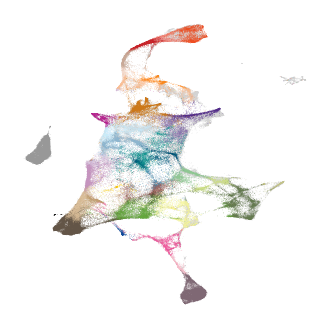

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(model_data, **celltype_umap_kwargs, ax = ax, basis = 'adj_umap', s= 0.5, show = False)
#plt.savefig('figure3/main/celltypes.png', bbox_inches = 'tight', dpi = 300)

<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

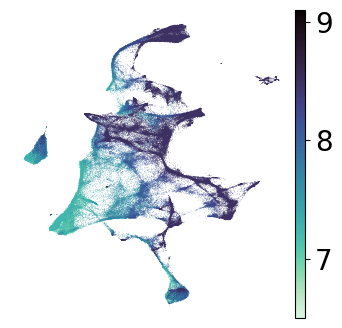

In [13]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(model_data, **day_umap_kwargs, ax = ax, basis = 'adj_umap', s= 0.5, show = False)
#plt.savefig('figure3/main/day.png', bbox_inches = 'tight', dpi = 300)

<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

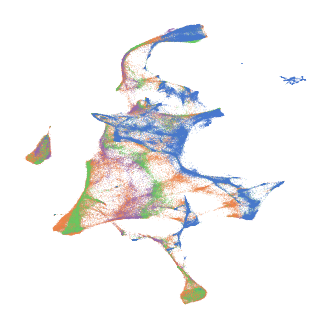

In [14]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(model_data, **batch_umap_kwargs, ax = ax, basis = 'adj_umap', s= 0.5, show = False)
#plt.savefig('figure3/main/batch.png', bbox_inches = 'tight', dpi = 300)

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = 30, metric='manhattan').fit(model_data.obsm['X_umap_features'].copy())
neighbors = nbrs.kneighbors(model_data.obsm['X_umap_features'])

In [15]:
model_data.obs['is_KO'] = model_data.obs.batch_id == '5.0'
model_data.obs.is_KO.sum()

56122

<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

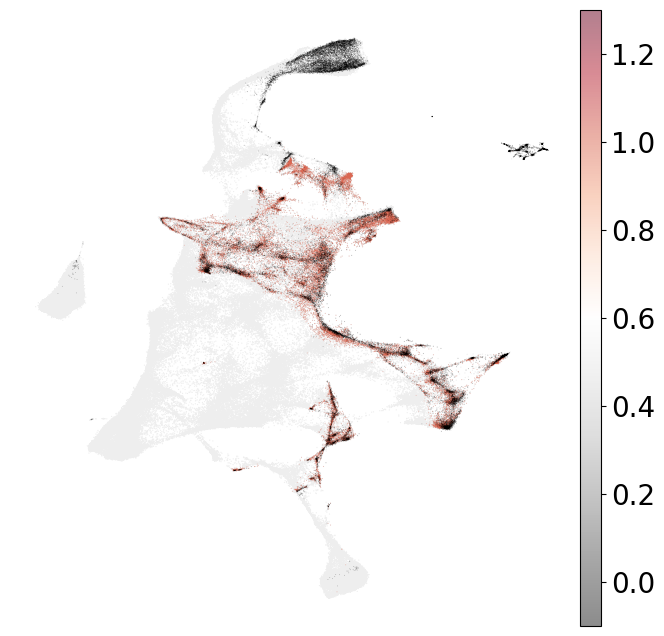

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, na_color='#EEEEEE', basis = 'adj_umap',
          frameon=False, color_map='RdBu_r', ax= ax, size = 3, show = False,
               alpha = 1.,)

sc.pl.embedding(model_data[model_data.obs.is_KO & model_data.obs.tomato.astype(bool)], vmax = 1.3, vmin = -0.1, alpha = 0.5,
          frameon=False, color_map='RdGy_r', ax= ax, size = 1.5, show = False, basis = 'adj_umap', color = 'tomato',)

sc.pl.embedding(model_data[model_data.obs.is_KO & ~model_data.obs.tomato.astype(bool)], vmax = 1.3, vmin = -0.1, alpha = 0.3,
          frameon=False, na_color = 'black', ax= ax, size = 1.5, show = False, basis = 'adj_umap')

#plt.savefig('figure3/main/tomato_overlay.png', bbox_inches = 'tight', dpi = 300)

from mira.plots.base import map_plot, plot_umap, map_colors

!mkdir -p sup3

from collections import defaultdict

day_order = sorted(model_data.obs.day.unique())[1:]
fig, ax = plt.subplots(3, len(day_order)//3, figsize = (8, 8))
palette = sns.color_palette('mako_r', len(day_order))

for ax_, day, color in zip(np.ravel(ax), day_order, palette):
    #& ~(model_data.obs.celltype.astype(str) == 'ExE ectoderm')
    sc.pl.embedding(model_data[(~model_data.obs.is_chimera)], size = 0.5, ax = ax_, show = False, frameon = False,
               na_color = '#EEEEEE', legend_loc= 'none', wspace=0, title = '', basis = 'adj_umap',
               legend_fontweight=200, legend_fontsize=10, palette=defaultdict(lambda : '#EEEEEE')
              )
    
    sc.pl.embedding(model_data[(model_data.obs.day == day) & ~model_data.obs.is_chimera], size = 1, frameon = False,
                    ax = ax_, show = False, color = 'celltype', palette=celltype_palette, legend_loc='none', basis = 'adj_umap',
                   na_color = color, wspace=0., hspace=0., legend_fontsize=8, legend_fontweight=150, title = '')
    
plt.savefig('sup3/celltypes_over_time.png', bbox_inches = 'tight', dpi = 300)

def topic_umap(ax, topic):
    
    ax = plot_umap(
        model_data.obsm['adj_umap'],
        model_data.obs_vector(topic),
        palette=sns.color_palette('light:blue', as_cmap=True),
        figsize=(5,5),
        size = 0.01,
        add_legend=False,
        vmin=-0.0,
        ax = ax,
        title = 'Topic ' + topic.split('_')[-1]
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, 
         [[x] for x, max_c in zip(model.topic_cols, model_data.obsm['X_topic_compositions'].max(0) > 0.1) if max_c], 
         plots_per_row=3, height=4, aspect=1.1)

plt.savefig('figure3/topics.png', bbox_inches = 'tight', dpi = 300)

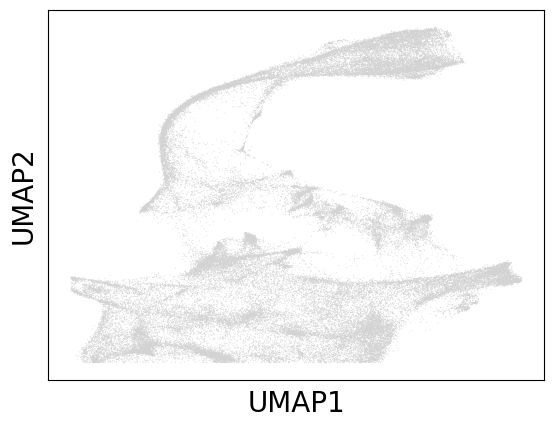

In [17]:
model_data.obs['in_zoomin'] = (model_data.obsm['X_umap'][:,0] > 6.5) & (model_data.obsm["X_umap"][:,1] > 7) & (model_data.obsm["X_umap"][:,0] < 13)
sc.pl.umap(model_data[model_data.obs.in_zoomin])

In [18]:
downsample = model_data[model_data.obs.in_zoomin]

In [19]:
model.predict(downsample)
model.impute(downsample)
model.get_batch_effect(downsample)

Predicting latent vars:   0%|          | 0/269 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57, topic_58, topic_59, topic_60, topic_61, topic_62
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/269 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/269 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect


In [20]:
#Pcolce, Tdo2 and Plagl1, Nkx2–5, Mef2c and Tnnt2

In [21]:
height_mask = (downsample.obsm["X_umap"][:,1] > 8.5)

In [22]:
downsample.obs['is_KO'] = downsample.obs.batch_id == '5.0'

<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

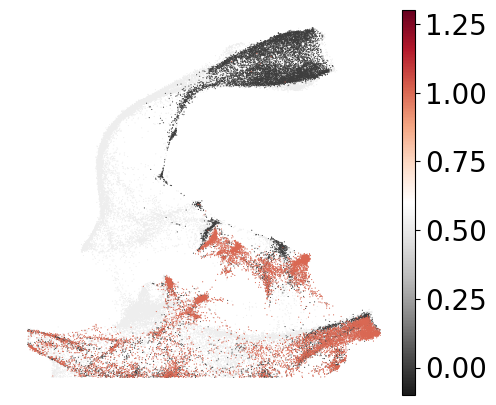

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5))
sc.pl.embedding(downsample[height_mask], na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 2.5, show = False, outline_width=(0.,1.01))

sc.pl.embedding(downsample[downsample.obs.is_KO & height_mask], color = 'tomato', vmax = 1.3, vmin = -0.1, alpha = 1.,
          frameon=False, color_map='RdGy_r', ax= ax, size = 2.5, show = False, basis = 'adj_umap', title = '')

#plt.savefig('figure3/main/tomato_inset.png', bbox_inches = 'tight', dpi = 300)

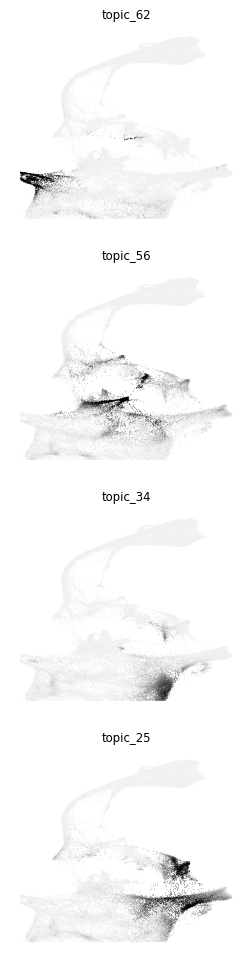

In [36]:
fig, ax = plt.subplots(4,1,figsize=(3, 3*4))
    
for topic, _ax, q in zip(['topic_62','topic_56','topic_34','topic_25'], np.ravel(ax),[0.98,0.98,1.,0.99]):
    plot_umap(downsample.obsm['X_umap'], downsample.obs_vector(topic),
              palette=sns.color_palette('light:black', as_cmap=True), 
              ax = _ax, 
              add_legend=False, 
              title = topic, 
              vmin = 0.015,
              vmax = np.quantile(downsample.obs_vector(topic), q= q),
              size = 0.25,
            edgecolor = None,
            linewidth = 0.
             )
    
plt.savefig('figure3/main/overlapping_topics.png', bbox_inches = 'tight', dpi = 300)

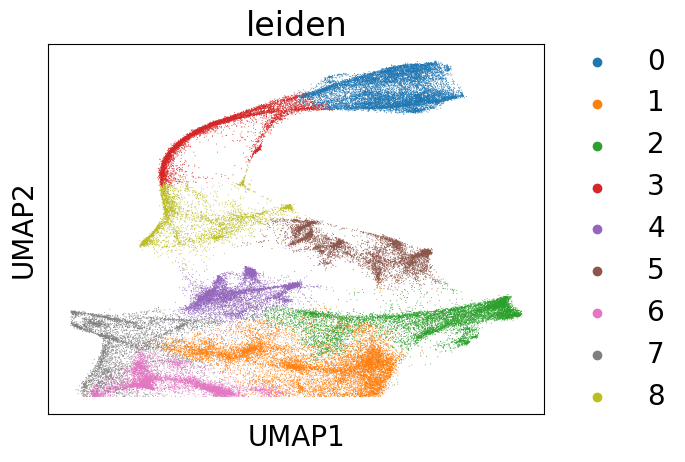

In [24]:
sc.pp.neighbors(downsample, use_rep='X_umap_features', metric = 'manhattan')

sc.tl.leiden(downsample, resolution = 0.3)
sc.pl.umap(downsample, color = 'leiden')

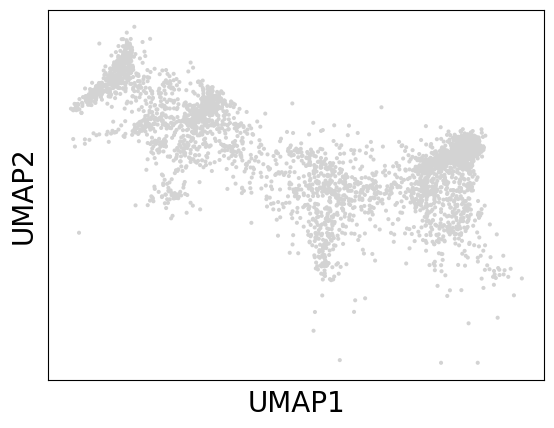

In [25]:
he_prog = downsample[(downsample.obs.leiden == '5') & (downsample.obsm['X_umap'][:,1] > 10) & downsample.obs.tomato & downsample.obs.is_KO]
sc.pl.umap(he_prog)

In [50]:
from matplotlib.colors import to_hex

In [51]:
for k,v in subcluster_palette.items():
    print(to_hex(v))

#fdd9a8
#fca26d
#e7533a
#ce2417
#ad0000


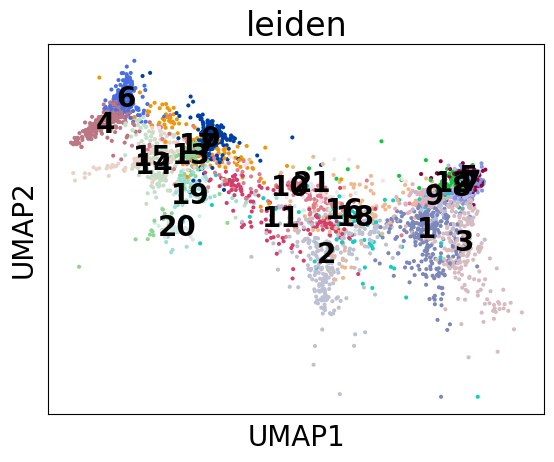

... storing 'new_celltype' as categorical


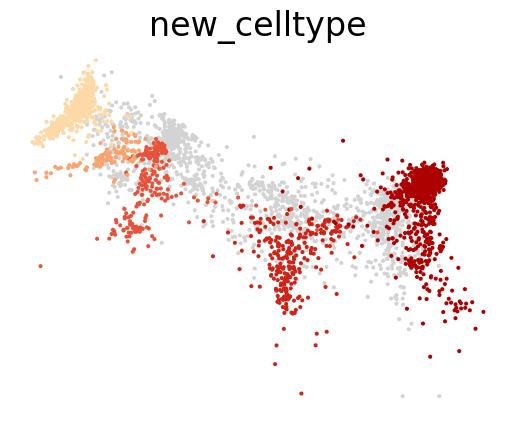

In [26]:
sc.pp.neighbors(he_prog, use_rep='X_umap_features', metric = 'manhattan')
sc.tl.leiden(he_prog, resolution=2)
sc.pl.umap(he_prog, color = 'leiden', legend_loc='on data')

from collections import defaultdict

cluster_agg = {
    (4,6,) : '\u0394Tal1: A',
    (15,) : '\u0394Tal1: B',
    (19,20,13): '\u0394Tal1: C',
    (2,) : '\u0394Tal1: D',
    (3,7,5,8,12) : '\u0394Tal1: E',
}

cmap = sns.color_palette('OrRd', n_colors=len(cluster_agg) + 3)
subcluster_palette = defaultdict(lambda : cmap[-1], {
    celltype : cmap[i + (i>0) + (i>1) + 1]
    for i, celltype in enumerate(cluster_agg.values())
})

cluster_key = {k : v for t, v in cluster_agg.items() for k in t}

he_prog.obs['new_celltype'] = he_prog.obs.leiden.astype(int).map(cluster_key)

sc.pl.umap(he_prog, color = 'new_celltype',
           palette=subcluster_palette, 
           frameon=False, legend_loc= 'none',
          na_color= 'lightgrey')

fig, ax = plt.subplots(2,3,figsize=(4*3, 4*2))
    
for gene, _ax in zip('ITGA2B, EMCN, MEF2C, TDO2, HOXB9, HMGCR'.upper().split(', '), np.ravel(ax)):
    l = downsample[height_mask].obs_vector(gene, layer = 'imputed')
    plot_umap(downsample[height_mask].obsm['X_umap'], l,
              palette=sns.color_palette('light:blue', as_cmap=True), 
              ax = _ax, size = 0.1, add_legend=False, title = gene, 
              vmax = np.quantile(l, 0.99) if gene in ['MEF2C','TDO2',] else None,
              vmin = 0)
#plt.savefig('figure3/author_genes_of_interest.png', bbox_inches = 'tight', dpi = 300)

In [27]:
downsample_celltype_palette = {str(k) + '::' : celltype_palette[k] for k in downsample.obs.celltype.unique()}
downsample.obs['celltype_faux'] = downsample.obs.celltype.astype(str) + '::'
downsample_celltype_palette['nan::'] = '#EEEEEE'


fig, ax = plt.subplots(3,3,figsize=(9,9,), sharex='col')

for g, ax_col in zip(['PLAGL1','HMGCR','MEF2C'], ax.T):

    dt.plots.disentanglement_plot(downsample, ax_col[2], g, color= 'batch_id',
                                  palette = list(batch_palette.values()),
                                  hue_order= list(batch_palette.keys())
                             )

    dt.plots.disentanglement_plot(downsample, ax_col[1], g, color= 'celltype_faux',
                                  palette = list(downsample_celltype_palette.values()),
                                  hue_order= list(downsample_celltype_palette.keys())
                                 )

    dt.plots.disentanglement_plot(downsample, ax_col[0], g, palette = sns.color_palette('light:blue', as_cmap=True))

plt.tight_layout()
#plt.savefig('figure3/disentanglement_panels.png',  bbox_inches = 'tight', dpi = 300)

In [28]:
downsample.obs['new_celltype'] = downsample.obs.index.map(he_prog.obs.new_celltype.astype(str).replace('nan', 'Misc').to_dict())

source_cell_mask = (downsample.obs.batch_id.astype(str) == '5.0') \
        & downsample.obs.tomato.astype(bool) \
        & ~downsample.obs.haem_closestcell.isna()

color_cells = downsample.obs.haem_closestcell[
    source_cell_mask & downsample.obs.haem_closestcell.isin(downsample.obs.cell)
].values.astype(str)

additional_zoom = (downsample.obsm['X_umap'][:,1] > 10.5) & (downsample.obsm['X_umap'][:,1] < 13)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'celltype_faux' as categorical
... storing 'new_celltype' as categorical
... storing 'celltype_faux' as categorical
... storing 'new_celltype' as categorical
... storing 'celltype_faux' as categorical
... storing 'new_celltype' as categorical


<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

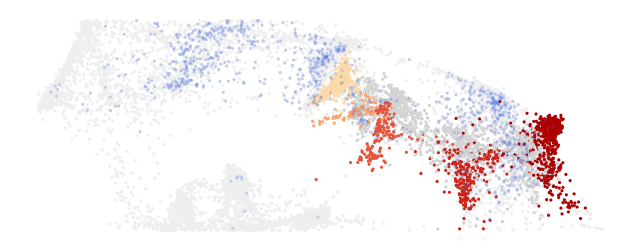

In [29]:
is_mapped_cell = downsample.obs['cell'].isin(color_cells)

fig, ax = plt.subplots(1,1,figsize=(8,3))
sc.pl.embedding(downsample[additional_zoom], na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 20, show = False, outline_width=(1.2,1.1))


sc.pl.embedding(downsample[additional_zoom & downsample.obs.is_KO & downsample.obs.tomato > 0], color = 'new_celltype',
                palette = {**subcluster_palette, 'Misc' : 'lightgrey'}, legend_loc='none', na_color='#EEEEEE',
          frameon=False, color_map='RdGy_r', ax= ax, size = 20, show = False, basis = 'adj_umap', title = '', alpha = 1.)

sc.pl.embedding(downsample[additional_zoom & is_mapped_cell], alpha = 0.25,
                na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
          frameon=False, ax= ax, size = 20, show = False, basis = 'adj_umap', title = '')

#plt.savefig('figure3/main/subclustered_KO_cells.png', bbox_inches = 'tight', dpi = 300)

In [30]:
downsample.obs['joined_celltypes'] = np.where(downsample.obs.celltype.isna(), 
         downsample.obs.new_celltype,
         downsample.obs.celltype
        )

collecting_map = {
    'EMCN+' : 'Endothelium',
    'MEF2C+' : 'Cardiomyocytes',
    'TDO2+' : 'Mesenchyme',
    'HOXB9+' : 'ExE mesoderm',
    'PLAGL1+' : 'Allantois',
}

bidirictional_collecting_map = collecting_map.copy()
bidirictional_collecting_map.update(
    {v : v for k, v in collecting_map.items()}
)

downsample.obs['overlap_groups'] = downsample.obs.joined_celltypes.map(bidirictional_collecting_map)

sc.pl.umap(downsample, color = 'overlap_groups')

downsample.uns['log1p']['base'] = None

sc.tl.rank_genes_groups(downsample, groupby='overlap_groups', reference='rest',
                        method='wilcoxon', use_raw = False)

In [37]:
from itertools import chain

... storing 'celltype_faux' as categorical
... storing 'new_celltype' as categorical
... storing 'joined_celltypes' as categorical


{'mainplot_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

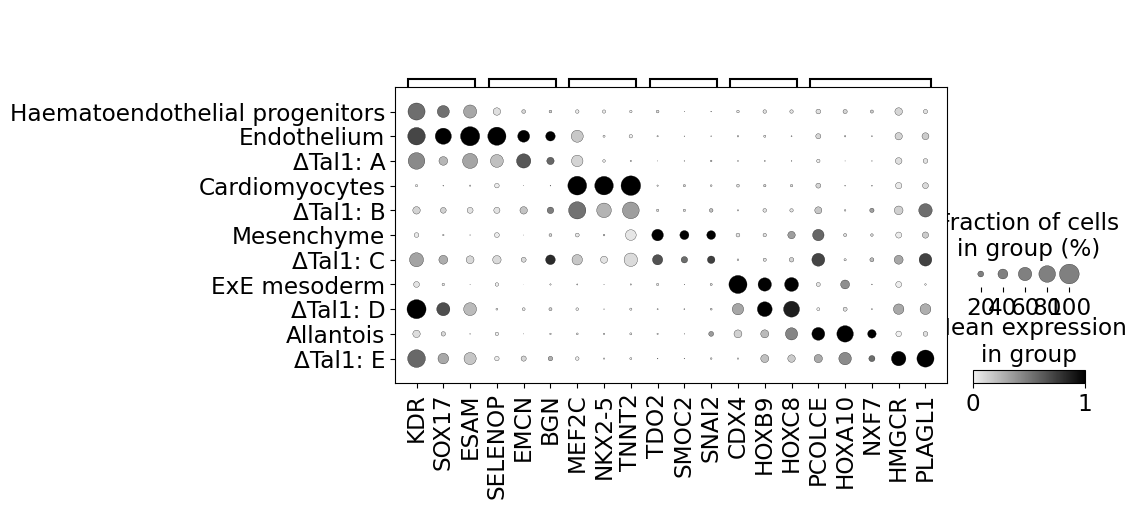

In [42]:
pops = ['Haematoendothelial progenitors'] + list(chain.from_iterable(zip(['Endothelium', 'Cardiomyocytes', 'Mesenchyme', 'ExE mesoderm','Allantois',],subcluster_palette.keys())))

marker_genes_dict = {
    '     ' : ['KDR','SOX17','ESAM'],
    '' : ['SELENOP','EMCN','BGN'],
    ' ' : ['MEF2C','NKX2-5','TNNT2'],
    '  ': ['TDO2','SMOC2','SNAI2'],
    '    ' : ['CDX4','HOXB9','HOXC8'],
    '   ' : ['PCOLCE','HOXA10','NXF7','HMGCR','PLAGL1'],
}

flat_genes = [v for k, vs in marker_genes_dict.items() for v in vs]
sc.pl.dotplot(downsample[downsample.obs.joined_celltypes.isin(pops)],
              marker_genes_dict, groupby='joined_celltypes', categories_order = pops, show=False, 
              standard_scale='var', color_map = sns.color_palette('light:black',as_cmap=True))

#plt.savefig('figure3/main/marker_gene_table.svg')

In [714]:
!realpath figure3/main/marker_gene_table.svg

/liulab/alynch/projects/multiomics/DisentanglerReproduction/figure3/main/marker_gene_table.svg


## DE gene analysis

In [31]:
chimera = model_data[model_data.obs.batch_id == '5.0'].copy()

isolated_he = he_prog[he_prog.obs.new_celltype.astype(str) != 'nan'].copy()

chimera.obs['in_HE_subclusters'] = chimera.obs_names.isin(isolated_he.obs_names)
chimera.obs['new_celltype' ] = chimera.obs.join(isolated_he.obs.new_celltype)['new_celltype']

chimera.uns['log1p']['base'] = np.e

In [33]:
isolated_he.uns['log1p']['base'] = np.e

In [34]:
sc.tl.rank_genes_groups(isolated_he, groupby ='new_celltype', reference='rest', use_raw = False,
                        method='wilcoxon', groups = subcluster_palette.keys())

chimera.obs['official_celltype' ] = np.where(
    chimera.obs['new_celltype'].astype(str).values == 'nan',
    chimera.obs['celltype.mapped'].values,
    chimera.obs['new_celltype'].values
)

In [ ]:
qref_pairs = dict(zip(subcluster_palette.keys(), ['Endothelium', 'Cardiomyocytes', 'Mesenchyme', 'ExE mesoderm','Allantois',]))

for query, ref in qref_pairs.items():
    sc.tl.rank_genes_groups(chimera, groupby='official_celltype', reference=ref,
                            groups=[query], use_raw = False, layers = None, method='wilcoxon', key_added=ref+'_diff')

varlist = pd.concat({q : sc.get.rank_genes_groups_df(isolated_he, group = q, pval_cutoff=0.05, log2fc_min = 1.5)
                     for q in subcluster_palette.keys()})\
        .drop_duplicates(subset = 'names').sort_values('pvals_adj').reset_index().groupby(['level_0'])['names'].apply(list).to_dict()

def get_different_genes(query, ref, screenset):
    d = sc.get.rank_genes_groups_df(chimera, key=ref+'_diff', group = query, pval_cutoff=0.01)
    return d[(np.abs(d.logfoldchanges) > 1.5)].sort_values('logfoldchanges', ascending=False)

allvars = [g for k,v in varlist.items() for g in v]

diffsets = pd.concat({q : get_different_genes(q, r, allvars)
           for q,r in qref_pairs.items()}).reset_index().sort_values('logfoldchanges')\
        .drop_duplicates(subset = 'names', keep = 'first').sort_values('logfoldchanges', ascending=False)\
        .groupby('level_0')['names'].apply(list).to_dict()

In [ ]:
genelists = {q : v + diffsets[q] for q, v in varlist.items()}
alltypes = [g for k,v in qref_pairs.items() for g in [k,v]]

In [ ]:
sc.pl.heatmap(chimera[chimera.obs.official_celltype.isin(qref_pairs.keys())], varlist,
              groupby='official_celltype',
            standard_scale = 'var', layer = None, use_raw = False, cmap = 'Greys', show = False)
plt.savefig('figure3/perturbed_DE_genes_heatmap.png', bbox_inches = 'tight', dpi = 300)

In [695]:
qref_pairs

{'ΔTal1: A': 'Endothelium',
 'ΔTal1: B': 'Cardiomyocytes',
 'ΔTal1: C': 'Mesenchyme',
 'ΔTal1: D': 'ExE mesoderm',
 'ΔTal1: E': 'Allantois'}

In [712]:
subcluster_de = {q : len(v) for q,v in varlist.items()}
subcluster_de

{'ΔTal1: A': 88,
 'ΔTal1: B': 95,
 'ΔTal1: C': 100,
 'ΔTal1: D': 63,
 'ΔTal1: E': 80}

In [713]:
extracluster_de = {q : len(v) for q,v in diffsets.items()}
extracluster_de

{'ΔTal1: A': 189,
 'ΔTal1: B': 144,
 'ΔTal1: C': 100,
 'ΔTal1: D': 72,
 'ΔTal1: E': 331}

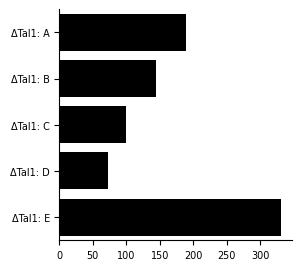

In [710]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.barplot(
    x = list(extracluster_de.values()),
    y = list(extracluster_de.keys()),
    color = 'black',
)
sns.despine()

In [698]:
chimera.obs.official_celltype.cat.reorder_categories(
    alltypes + list(set(chimera.obs.official_celltype.cat.categories).difference(alltypes)), inplace = True
)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  


/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


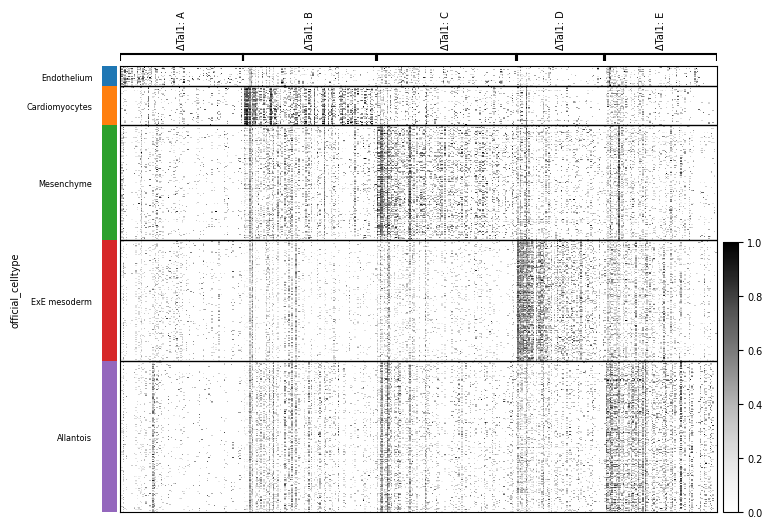

In [699]:
sc.pl.heatmap(chimera[chimera.obs.official_celltype.isin(qref_pairs.values())], varlist,
              groupby='official_celltype',
            standard_scale = 'var', layer = None, use_raw = False, cmap = 'Greys', show = False)
plt.savefig('figure3/WT_DE_genes_heatmap.png', bbox_inches = 'tight', dpi = 300)

def montecarlo_DE():
    
    cluster = chimera[
        chimera.obs['celltype.mapped'] == np.random.choice(chimera.obs['celltype.mapped'].cat.categories)
    ]
    
    print(cluster)

    cluster.obs['random_division'] = (np.random.rand(len(cluster)) < np.random.beta(3,3)).astype(str)

    sc.tl.rank_genes_groups(cluster, use_raw=False, layer=None, method='wilcoxon',
                            groupby = 'random_division', reference = 'False', groups = ['True'])

    results = sc.get.rank_genes_groups_df(cluster, group = 'True', pval_cutoff=0.05)

    return (np.abs(results.logfoldchanges.values) > 1.5).sum()

montecarlo_DE()

# Confounded MIRA

In [625]:
confounded_design_matrix = {
    '1.0' : ['E6.5','E6.75','E7.0',],
    '2.0' : ['E7.25', 'E7.5','E7.75','E8.25'],
    '3.0' : ['E8.0','E8.5'],
    '4.0' : ['E7.5', 'E8.5'],
    '5.0' : ['E8.5'],
}

model_data.obs['in_confounding_experiment'] = [
    s in confounded_design_matrix[b] and (t == True if b == '5.0' else True)
    for b,s,t in model_data.obs[['batch_id','stage','tomato']].values
]

In [50]:
!mkdir -p figure3/confounded/

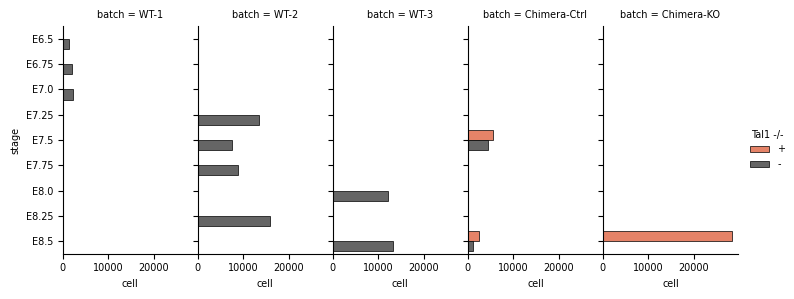

In [51]:
batch_v_stage = model_data[model_data.obs.in_confounding_experiment].obs.groupby(['sequencing.batch','stage','Tal1 -/-']).count()['cell'].reset_index()
#batch_v_stage['clipped_cell'] = np.clip(batch_v_stage.cell,0., 2e4)

batch_v_stage['batch'] = batch_v_stage['sequencing.batch'].map({1.0 : 'WT-1', 2.0 : 'WT-2', 3.0 : 'WT-3',
                                      4.0 : 'Chimera-Ctrl', 5.0 : 'Chimera-KO'})

sns.catplot(
    data = batch_v_stage,
    col='batch',
    y='stage',
    x = 'cell',
    kind='bar',
    order = sorted(batch_v_stage.stage.unique().astype(str)),
    palette= {'+' : sns.color_palette('RdGy', n_colors=7)[1], '-' : sns.color_palette('RdGy')[-1]},
    hue = 'Tal1 -/-',
    aspect = 0.5,
    height = 3.,
    linewidth = 0.5,
    edgecolor = 'black',
    saturation = 1.,
    dodge = True,
    facet_kws = dict(gridspec_kws = dict(wspace = 0.)),
)
#plt.savefig('figure3/confounded/batch_cell_heatmap.svg')

In [626]:
confounded_data = model_data[model_data.obs.in_confounding_experiment]

In [627]:
confounded_model = mira.topics.TopicModel(
    int(model_data.obs.in_confounding_experiment.sum()), model_data.n_vars,
    categorical_covariates=['batch_id','is_chimera','is_mixed_embryos'],
    continuous_covariates=['day'],
    exogenous_key='exog',
    latent_space='dirichlet',
    feature_type='expression',
    counts_layer='counts',
    min_learning_rate = 0.001,
    max_learning_rate = 0.1,
)

In [88]:
confounded_data.obs['batch-stage-group'] = list(map(lambda b : '{}-{}'.format(*b), confounded_data.obs[['batch_id','stage']].values))

train, test = mira.topics.SpeedyTuner.train_test_split(confounded_data, stratify=confounded_data.obs_vector('batch-stage-group'), train_size = 0.9)

confounded_model.write_ondisk_dataset(train, dirname=folder+'confounded_train')
confounded_model.write_ondisk_dataset(test, dirname=folder+'confounded_test')

del train, test

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog


Writing dataset to disk:   0%|          | 0/105 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog


Writing dataset to disk:   0%|          | 0/12 [00:00<?, ?it/s]

In [89]:
tuner = mira.topics.SpeedyTuner(
    model = confounded_model,
    min_trials = 64,
    max_trials = 128,
    min_topics = 35,
    max_topics = 80,
    stop_condition=12,
    n_jobs=15,
    storage=mira.topics.Redis(),
    save_name = 'embryo/rna/confounded/final/0'
)

tuner.purge()

In [ ]:
tuner.fit(
    folder+'confounded_train',
    folder+'confounded_test'
)

In [91]:
print(tuner)

Trials finished: 81 | Best trial: 48 | Best score: 1.8204e+03
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/embryo/rna/confounded/final/0
#Topics | #Trials 

     39 | ■ 
     40 | ■ 
     41 | ■ 
     42 | ■ 
     43 | ■ ■ 
     44 | ■ ■ ■ ■ ■ 
     46 | ■ 
     48 | ■ ■ 
     50 | ■ 
     51 | ■ ■ 
     52 | ■ 
     53 | ■ 
     54 | ■ 
     57 | ■ 
     58 | ■ ■ ■ ■ ■ ■ 
     61 | ■ 
     62 | ■ ■ 
     63 | ■ ■ ■ ■ ■ ■ ■ 
     66 | ■ ■ ■ ■ 
     67 | ■ ■ ■ 
     68 | ■ ■ ■ 
     69 | ■ ■ 
     71 | ■ 
     73 | ■ ■ ■ ■ ■ ■ 
     74 | ■ 
     76 | ■ ■ 
     77 | ■ 
     78 | ■ 
     79 | ■ ■ ■ ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   |   | pruned at step: 8            | {'num_topics': 40, 'decoder_dropout': 0.1015}
 #1   |   | pruned at step: 8            | {'num_topics': 79, 'decoder_dropout': 0.1740}
 #5   |   | completed, score: 1.8244e+03 | {'num_topics': 50, 'decoder_dropout': 0.0602}
 #7   |   | pruned at s

In [628]:
#confounded_model = tuner.fetch_best_weights()
confounded_model = mira.topics.load_model('data/embryo/confounded_model.pth')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


confounded_model.save('data/embryo/confounded_model.pth')

confounded_model = mira.topics.load_model('data/embryo/confounded_model.pth')

In [629]:
confounded_model.predict(confounded_data)

Predicting latent vars:   0%|          | 0/464 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [630]:
confounded_model.get_umap_features(confounded_data, box_cox=0.25)
sc.pp.neighbors(confounded_data, use_rep='X_umap_features', metric = 'manhattan')
sc.tl.umap(confounded_data, min_dist=0.1 ,negative_sample_rate=3)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [631]:
theta = np.pi/15
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [632]:
newcoors = np.dot(confounded_data.obsm["X_umap"] * np.array([[-1,1]]), rot)
confounded_data.obsm['adj_umap'] = np.where((newcoors[:,0] < -5)[:,None], newcoors + np.array([[3, 0]]), newcoors)

<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

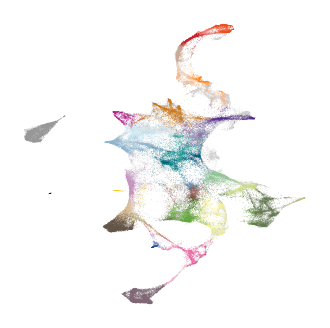

In [633]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(confounded_data, **celltype_umap_kwargs, ax = ax, basis = 'adj_umap', s= 0.5, show = False)
#plt.savefig('figure3/confounded/celltypes.png', bbox_inches = 'tight', dpi = 300)

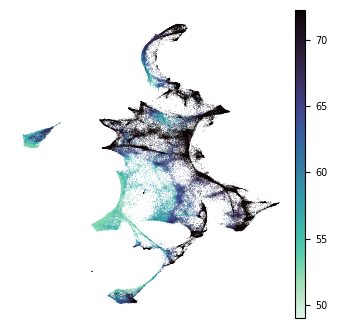

In [60]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(confounded_data, **day_umap_kwargs, ax = ax, 
                basis = 'adj_umap', s= 0.5, show = False)
plt.savefig('figure3/confounded/day.png', bbox_inches = 'tight', dpi = 300)

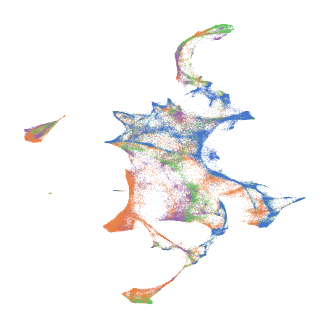

In [141]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(confounded_data, **batch_umap_kwargs, ax = ax,
                basis = 'adj_umap', s= 0.5, show = False)
plt.savefig('figure3/confounded/batch.png', bbox_inches = 'tight', dpi = 300)

In [634]:
confounded_data.obs['in_downsample'] = confounded_data.obs_names.isin(downsample.obs_names)
#confounded_data.obs['in_additional_zoom'] = confounded_data.obs_names.isin(downsample.obs_names[additional_zoom])

In [635]:
theta = -np.pi/7
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

confounded_data.obsm['rot_umap'] = confounded_data.obsm['adj_umap'].dot(rot)

In [636]:
confounded_downsample = confounded_data[#confounded_data.obs.in_downsample  \
                                 (confounded_data.obsm['rot_umap'][:,1] > 12.2) \
                                & (confounded_data.obsm['rot_umap'][:,0] < -0.5) ]

In [637]:
confounded_model.impute(confounded_downsample)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/77 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


fig, ax = plt.subplots(2,3,figsize=(4*3, 4*2))
    
for gene, _ax in zip('ITGA2B, EMCN, MEF2C, TDO2, HOXB9, HMGCR'.upper().split(', '), np.ravel(ax)):
    plot_umap(confounded_downsample.obsm['adj_umap'], confounded_downsample.obs_vector(gene, layer = 'imputed'),
              palette=sns.color_palette('light:blue', as_cmap=True), 
              ax = _ax, size = 0.1, add_legend=False, title = gene)
plt.savefig('figure3/confounded/marker_genes.png', bbox_inches = 'tight', dpi = 300)

fig, ax = plt.subplots(1,1,figsize=(5.5,5))
sc.pl.embedding(confounded_downsample, na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 2.5, show = False, outline_width=(0.,1.01))

sc.pl.embedding(confounded_downsample[confounded_downsample.obs.is_KO & (confounded_downsample.obs.tomato > 0)], color = 'tomato', vmax = 1.3, vmin = -0.1,
          frameon=False, color_map='RdGy_r', ax= ax, size = 2.5, show = False, basis = 'adj_umap', title = '', alpha = 1.)

is_mapped_cell = confounded_downsample.obs['cell'].isin(color_cells)
sc.pl.embedding(confounded_downsample[ is_mapped_cell], 
               na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
              frameon=False, ax= ax, size = 5, show = False, basis = 'adj_umap', title = '')

plt.savefig('figure3/confounded/projected_neighbors.png', bbox_inches = 'tight', dpi = 300)

In [638]:
#confounded_downsample.obs['is_KO'] = confounded_downsample.obs.batch_id == '5.0'
#confounded_downsample.obs['new_celltype'] = confounded_downsample.obs.index.map(he_prog.obs.new_celltype.astype(str).replace('nan', 'Misc').to_dict())

#is_mapped_cell = confounded_downsample.obs['cell'].isin(color_cells)
height_mask = confounded_downsample.obsm['rot_umap'][:,1] > 13.2

In [647]:
confounded_downsample.obs.drop(columns=['new_celltype'], inplace=True)
confounded_downsample.obs['new_celltype'] = confounded_downsample.obs.join(he_prog.obs.new_celltype)['new_celltype']

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

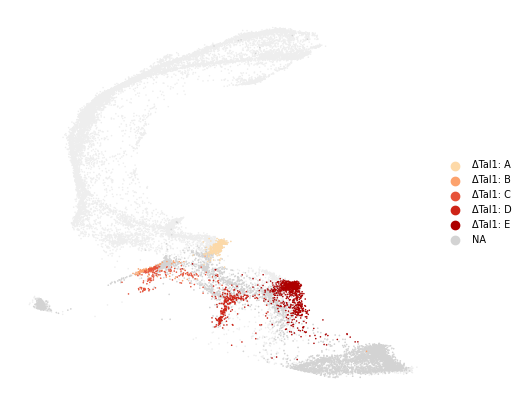

In [654]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5))
sc.pl.embedding(confounded_downsample,
                na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, palette=celltype_palette, ax= ax, size = 5, show = False, outline_width=(0.,1.01))

sc.pl.embedding(confounded_downsample[confounded_downsample.obs.is_KO], #color = 'tomato', #vmax = 1.3, vmin = -0.1, alpha = 1.,
          frameon=False, palette = subcluster_palette, ax= ax, size = 5, show = False, basis = 'adj_umap', title = '',color = 'new_celltype',)

#plt.savefig('figure3/confounded/tomato_inset.png', bbox_inches = 'tight', dpi = 300)

confounded_downsample.obs['new_celltype'] = confounded_downsample.obs.index.map(he_prog.obs.new_celltype.astype(str).replace('nan', 'Misc').to_dict())

fig, ax = plt.subplots(1,1,figsize=(8,5))
sc.pl.embedding(confounded_downsample[height_mask], na_color='#EEEEEE', basis = 'rot_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 40, show = False, outline_width=(0.,1.01))


sc.pl.embedding(confounded_downsample[height_mask & confounded_downsample.obs.is_KO & confounded_downsample.obs.tomato > 0], color = 'new_celltype',
                palette = {**subcluster_palette, 'Misc' : 'lightgrey'}, legend_loc='none', na_color='#EEEEEE',
          frameon=False, color_map='RdGy_r', ax= ax, size = 40, show = False, basis = 'rot_umap', title = '', alpha = 1.)

sc.pl.embedding(confounded_downsample[height_mask & is_mapped_cell], alpha = 0.3, 
                na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
          frameon=False, ax= ax, size = 40, show = False, basis = 'rot_umap', title = '')

#plt.savefig('figure3/confounded/subclustered_KO_cells.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sc.pl.embedding(confounded_downsample[height_mask], na_color='#EEEEEE', basis = 'rot_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 40, show = False, outline_width=(0.,1.01))


sc.pl.embedding(confounded_downsample[height_mask & confounded_downsample.obs.is_KO & confounded_downsample.obs.tomato > 0], color = 'new_celltype',
                palette = {**subcluster_palette, 'Misc' : 'lightgrey'}, legend_loc='none', na_color='#EEEEEE',
          frameon=False, color_map='RdGy_r', ax= ax, size = 40, show = False, basis = 'rot_umap', title = '', alpha = 1.)

sc.pl.embedding(confounded_downsample[height_mask & is_mapped_cell], alpha = 0.3, 
                na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
          frameon=False, ax= ax, size = 40, show = False, basis = 'rot_umap', title = '')

#plt.savefig('figure3/confounded/subclustered_KO_cells.png', bbox_inches = 'tight', dpi = 300)

fig, ax = plt.subplots(1,1,figsize=(8,5))
sc.pl.embedding(confounded_downsample[height_mask], na_color='#EEEEEE', basis = 'rot_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 40, show = False, outline_width=(0.,1.01))


sc.pl.embedding(confounded_downsample[height_mask & confounded_downsample.obs.is_KO & confounded_downsample.obs.tomato > 0], color = 'new_celltype',
                palette = {**subcluster_palette, 'Misc' : 'lightgrey'}, legend_loc='none', na_color='#EEEEEE',
          frameon=False, color_map='RdGy_r', ax= ax, size = 40, show = False, basis = 'rot_umap', title = '', alpha = 1.)

sc.pl.embedding(confounded_downsample[height_mask & is_mapped_cell], alpha = 0.3, 
                na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
          frameon=False, ax= ax, size = 40, show = False, basis = 'rot_umap', title = '')

#plt.savefig('figure3/confounded/subclustered_KO_cells.png', bbox_inches = 'tight', dpi = 300)

In [170]:
height_mask = (confounded_downsample.obsm['rot_umap'][:,1] > 12.75) & \
     (confounded_downsample.obsm['rot_umap'][:,1]  < 16.1) & \
     (confounded_downsample.obs.celltype.astype(str) != 'Mesenchyme') & \
     (np.array([downsample.obs.loc[o].leiden if o in downsample.obs_names else False
               for o in confounded_downsample.obs_names]) != '2')

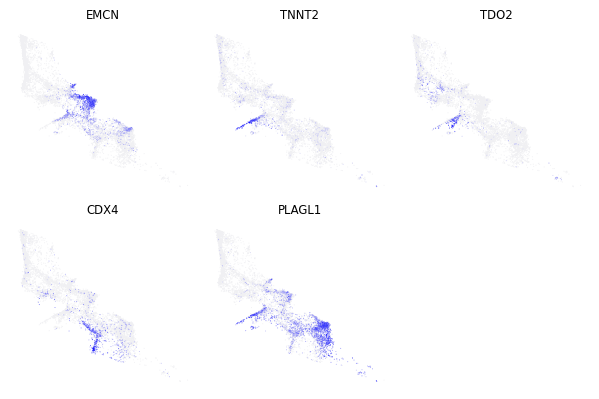

In [177]:
def zoomin_marker(ax, gene):
    
    ax = plot_umap(
        confounded_downsample[height_mask].obsm['adj_umap'],
        confounded_downsample[height_mask].obs_vector(gene, layer = None),
        palette=sns.color_palette('light:blue', as_cmap=True),
        size = 0.5,
        add_legend=False,
        vmin=-0.0,
        linewidth = 0.,
        ax = ax,
        title = gene
    )
    ax.set_xmargin(0.05)
    ax.set_xmargin(0.05)


map_plot(zoomin_marker, 
         [[g] for g in ['EMCN','TNNT2','TDO2','CDX4','PLAGL1']], 
         plots_per_row=3, height=2, aspect=1)
plt.tight_layout()
plt.savefig('figure3/confounded/marker_genes.png', bbox_inches = 'tight', dpi = 300)

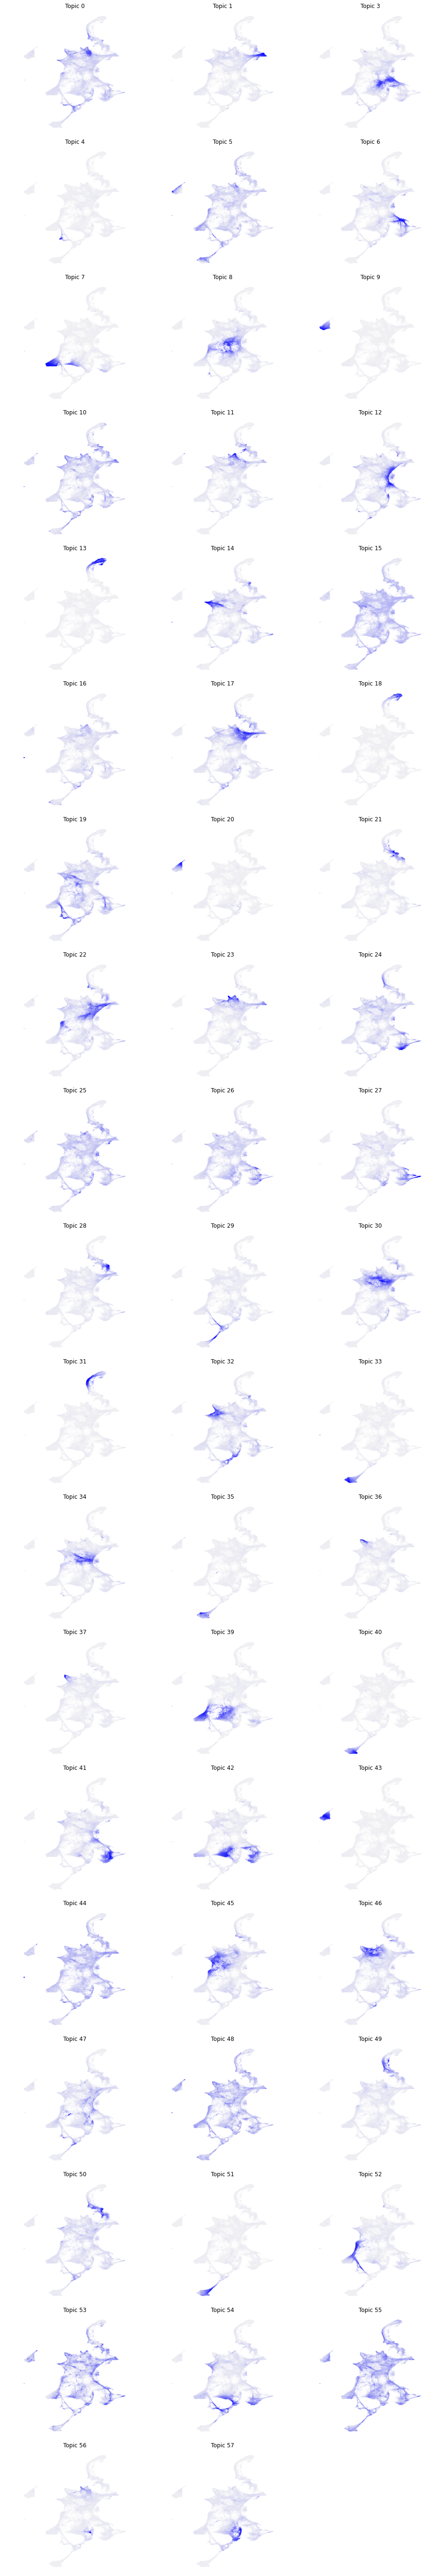

In [681]:
def topic_umap(ax, topic):
    
    ax = plot_umap(
        confounded_data.obsm['adj_umap'],
        confounded_data.obs_vector(topic),
        palette=sns.color_palette('light:blue', as_cmap=True),
        figsize=(5,5),
        size = 0.01,
        add_legend=False,
        vmin=-0.0,
        ax = ax,
        title = 'Topic ' + topic.split('_')[-1]
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, 
         [[x] for x, max_c in zip(model.topic_cols, confounded_data.obsm['X_topic_compositions'].max(0) > 0.1) if max_c], 
         plots_per_row=3, height=4, aspect=1.1)

plt.savefig('figure3/confounded/topics.png', bbox_inches = 'tight', dpi = 300)

# Author's manifold

In [95]:
model_data.obsm['X_author_umap'] = model_data.obs[['umapX', 'umapY']].values.copy()

In [689]:
!mkdir -p figure3/author

... storing 'celltype_faux' as categorical


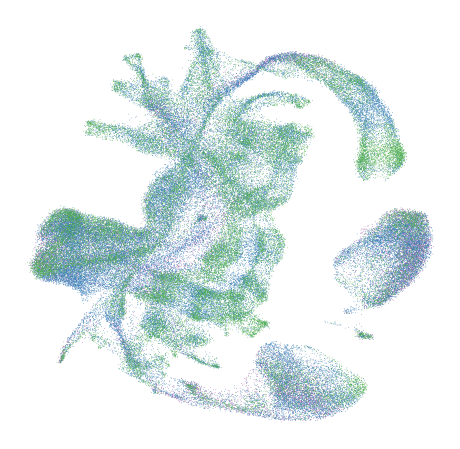

In [96]:
def convert_kwargs(kwargs):
    kwargs.pop('s')
    kwargs['s'] = 8
    return kwargs

fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, ax = ax, **batch_umap_kwargs, s = 2, basis = 'X_author_umap', show = False)
plt.savefig('figure3/author/batch.png', bbox_inches = 'tight', dpi = 300)

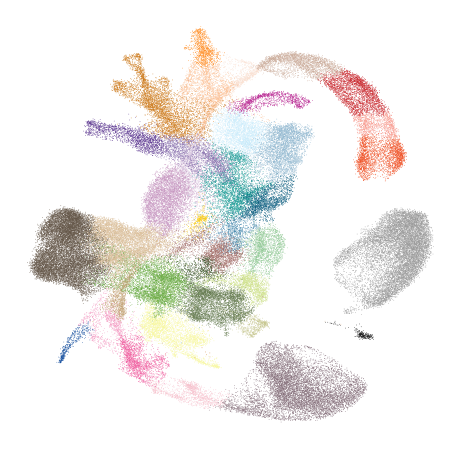

In [97]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, ax = ax, **celltype_umap_kwargs, s =2, basis = 'X_author_umap', show = False)
plt.savefig('figure3/author/celltypes.png', bbox_inches = 'tight', dpi = 300)

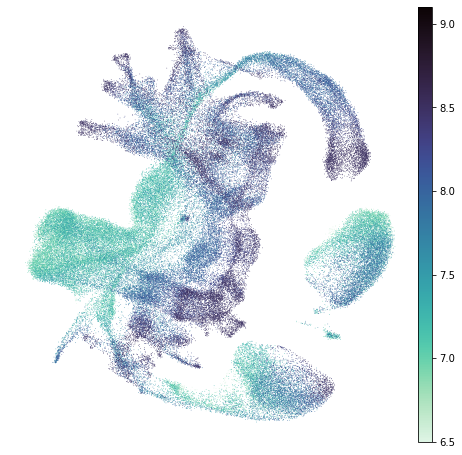

In [98]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, ax = ax, **day_umap_kwargs, s = 2, basis = 'X_author_umap', show = False)
plt.savefig('figure3/author/day.png', bbox_inches = 'tight', dpi = 300)

## scVI testing

In [57]:
from sklearn.base import BaseEstimator
from scvi.model import SCVI

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [58]:
class scVI_Estimator(BaseEstimator):

    def __init__(self, 
        n_latent = 30,
        counts_layer = None,
        continuous_covariates = None,
        categorical_covariates = None,
        n_hidden = 128,
        n_layers = 1,
        dropout_rate = 0.1,
        gene_likelihood = 'nb',
        max_epochs = None,
    ):
        self.n_latent = n_latent
        self.continuous_covariates = continuous_covariates
        self.categorical_covariates = categorical_covariates
        self.counts_layer = counts_layer
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.gene_likelihood = gene_likelihood
        self.max_epochs = max_epochs

    def _setup_anndata(self, X):

        adata = X.copy()

        SCVI.setup_anndata(
                adata, 
                layer = self.counts_layer,
                categorical_covariate_keys=self.categorical_covariates,
                continuous_covariate_keys=self.continuous_covariates,
            )

        return adata


    def fit(self, X):

        self.model_ = SCVI(
            self._setup_anndata(X), 
            n_latent = self.n_latent,
            gene_likelihood = self.gene_likelihood,
            n_hidden = self.n_hidden,
            n_layers = self.n_layers,
            dropout_rate = self.dropout_rate,
        )

        self.model_.train(
                max_epochs = self.max_epochs,
                train_size = 1.0,
            )

    def score(self, X):
        assert self.model_.is_trained

        return self.model_.get_elbo(
            self._setup_anndata(X)
        )

    def predict(self, X):
        assert self.model_.is_trained

        return self.model_.get_latent_representation(
            self._setup_anndata(X)
        )

In [82]:
scvi_model = scVI_Estimator(n_latent=30,
                            counts_layer = 'counts',
                            categorical_covariates=['batch_id','is_chimera','is_mixed_embryos'],
                            continuous_covariates=['day'],)
scvi_model.fit(model_data)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU avai

Epoch 43/43: 100%|████████████████████████████████████████████████████████████████████████████| 43/43 [45:52<00:00, 64.02s/it, loss=1.72e+03, v_num=1]


In [84]:
!rm -rf data/embryo/main_scvi_model.pth

In [85]:
scvi_model.model_.save('data/embryo/main_scvi_model.pth')

In [86]:
scvi_model = SCVI.load('data/embryo/main_scvi_model.pth', model_data)

INFO     File data/embryo/main_scvi_model.pth/model.pt already downloaded                    


In [87]:
model_data.obsm['scvi_features'] = scvi_model.get_latent_representation()

In [88]:
#confounded_model.get_umap_features(confounded_data, box_cox=0.2)
sc.pp.neighbors(model_data, use_rep='scvi_features')
sc.tl.umap(model_data, min_dist=0.1 ,negative_sample_rate=3)

<AxesSubplot:xlabel='X_umap1', ylabel='X_umap2'>

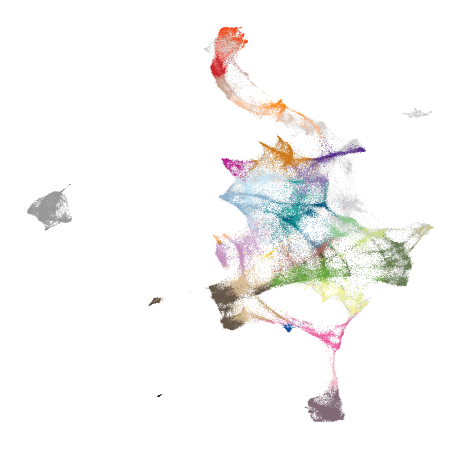

In [89]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, **celltype_umap_kwargs, ax = ax, basis = 'X_umap', s= 1.5, show = False)
#plt.savefig('figure3/main/celltypes.png', bbox_inches = 'tight', dpi = 300)

<AxesSubplot:title={'center':'tomato'}, xlabel='X_umap1', ylabel='X_umap2'>

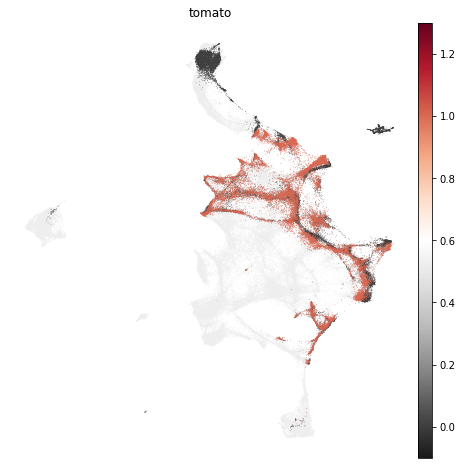

In [90]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, na_color='#EEEEEE', basis = 'X_umap',
          frameon=False, color_map='RdBu_r', ax= ax, size = 1.5, show = False)

sc.pl.embedding(model_data[model_data.obs.is_KO], color = 'tomato', vmax = 1.3, vmin = -0.1,
          frameon=False, color_map='RdGy_r', ax= ax, size = 1.5, show = False, basis = 'X_umap')

#lt.savefig('figure3/main/tomato_overlay.png', bbox_inches = 'tight', dpi = 300)

In [91]:
confounded_scvi_model = scVI_Estimator(n_latent=30, max_epochs = None,
                            counts_layer = 'counts',
                            categorical_covariates=['batch_id','is_chimera','is_mixed_embryos'],
                            continuous_covariates=['day'],)
confounded_scvi_model.fit(confounded_data)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU avai

Epoch 67/67: 100%|████████████████████████████████████████████████████████████████████████████| 67/67 [24:18<00:00, 21.77s/it, loss=1.77e+03, v_num=1]


In [92]:
!rm -rf data/embryo/confounded_scvi_model.pth

In [93]:
confounded_scvi_model.model_.save('data/embryo/confounded_scvi_model.pth')

In [94]:
confounded_scvi_model = SCVI.load('data/embryo/confounded_scvi_model.pth', confounded_data.copy())

INFO     File data/embryo/confounded_scvi_model.pth/model.pt already downloaded              


In [95]:
confounded_data.obsm['scvi_features'] = confounded_scvi_model.get_latent_representation()

In [96]:
#confounded_model.get_umap_features(confounded_data, box_cox=0.2)
sc.pp.neighbors(confounded_data, use_rep='scvi_features')
sc.tl.umap(confounded_data, min_dist=0.1 ,negative_sample_rate=3)

<AxesSubplot:xlabel='X_umap1', ylabel='X_umap2'>

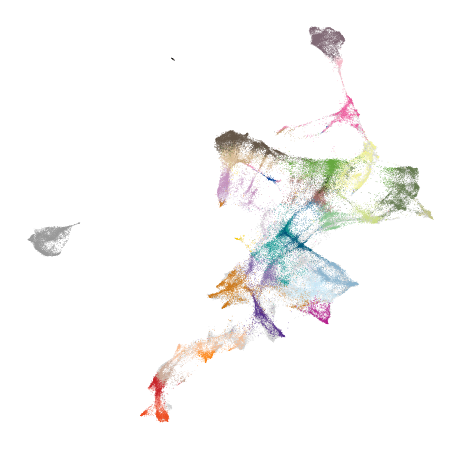

In [97]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(confounded_data, **celltype_umap_kwargs, ax = ax, basis = 'X_umap', s= 1.5, show = False)
#plt.savefig('figure3/main/celltypes.png', bbox_inches = 'tight', dpi = 300)

[<AxesSubplot:title={'center':'MEF2C'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <AxesSubplot:title={'center':'TNNT2'}, xlabel='X_umap1', ylabel='X_umap2'>]

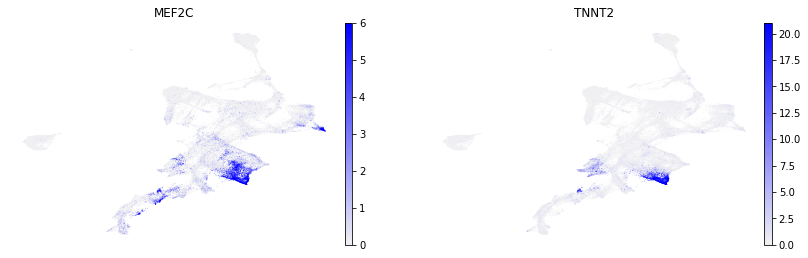

In [103]:
sc.pl.embedding(confounded_data, color = ['MEF2C','TNNT2'], basis = 'X_umap',
          frameon=False, size = 1.5, show = False,vmax = 'p99',
        color_map=sns.color_palette('light:blue', as_cmap=True))

<AxesSubplot:title={'center':'tomato'}, xlabel='X_umap1', ylabel='X_umap2'>

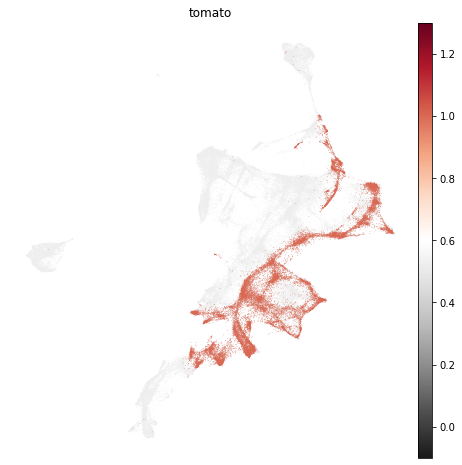

In [98]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(confounded_data, na_color='#EEEEEE', basis = 'X_umap',
          frameon=False, color_map='RdBu_r', ax= ax, size = 1.5, show = False)

sc.pl.embedding(confounded_data[confounded_data.obs.is_KO], color = 'tomato', vmax = 1.3, vmin = -0.1,
          frameon=False, color_map='RdGy_r', ax= ax, size = 1.5, show = False, basis = 'X_umap')

#lt.savefig('figure3/main/tomato_overlay.png', bbox_inches = 'tight', dpi = 300)